## What is Machine Learning Model Deployment?

**Machine Learning Model Deployment** is the process of making your machine learning Model accessible to someone or something else.

**Someone** else being a person who can interact with your Model in some way and **something** else might be another program, app or even another model that interacts with it.

## Why Deploying a Machine Learning Model?

Deploying a model is as important as training one.

Because although you can get a pretty good idea of how your Model's going to function by evaluting it on a well crafted test set or visualizing its results, you never really know how it's going to `perform` until you release it to the wild.

For example, what happens if someone was to upload a photo that wasn't of food to our `FoodVision Mini` model?
* A solution could be to create another Model that first classifies images as `food` or `not food` and passing the target image through that model first.

## What's the Best Practice for Deploying a Model?

There is not a `best-practice`, whole books have been written on the different types we can deploy a Model, but a great start is answer the question:

- What is the most ideal scenario for my machine learning Model to be used?

After answering this question we can work backwords from there and figure the `best`, in our case, way to deploy our Model.

In fact we need to answer 2 more questions:
1. Where's it going to go (to be stored)?
2. How's it going to function (return predictions immediately)?

The main debate about question 1 is: store it `on-device` or on the `cloud`. For more check: https://machinethink.net/blog/machine-learning-device-or-cloud/

The main debate about question 2 is: `online(real-time)` or `offline(batch)`. For more check: https://www.qwak.com/post/online-vs-offline-machine-learning-whats-the-difference

## What are the Ways (`where`) we can Deploy our Model?

Some off the resources that help us deploy our Model are:
* `Google's ML Kit` (on-device)
* `Apple's Core ML` (on-device)
* `Amazon Web Service's (AWS) Sagemaker` (cloud)
* `Google Cloud's Vertex AI`(cloud)
* `Microsoft's Azure Machine Learning` (cloud)
* `Hugging Face Spaces` (cloud)
* `API with FastAPI` (cloud/self-hosted server)
* `API with TorchServe` (cloud/self-hosted server)

## What are we Going to Do?

Our goal is to `deploy` our **FoodVision** Model via a demo [Gradio App](https://gradio.app/) on [Hugging Face Spaces](https://huggingface.co/spaces).

In [2]:
import torch
from torch import nn, optim
from torchvision import models

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
!pip install -q torchinfo

In [4]:
from torchinfo import summary
from pathlib import Path
from tqdm.auto import tqdm
from timeit import default_timer as timer
from PIL import Image

In [5]:
from drive.MyDrive.going_modular.going_modular import data_setup, engine, utils

## Setting up Default Device

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


## Loading the Dataset (20% for the Pizza/Steak/Sushi Dataset)

In [7]:
# The function for Downloading a `zip` formated Dataset:
def download_data(source: str, destination: str, remove_source: bool=True):
    import requests
    import zipfile
    from pathlib import Path
    from os import remove


    # Setting the path in which the Dataset is going to be saved
    dataset_path = Path(destination)

    if dataset_path.is_dir():
        print(f"[INFO] {dataset_path} already exists, skipping download...")
    else:
        print(f"[INFO] {dataset_path} doesn't exists, creating one...")

        dataset_path.mkdir(parents=True, exist_ok=True)

        # Getting the name of the Dataset
        target_file = Path(destination).name

        with open(destination + '/' + target_file, "wb") as f:
            # Getting the raw Dataset from `github`
            req = requests.get(source)
            
            print(f"[INFO] Downloading {target_file} from {source}...")
            
            f.write(req.content)

        with zipfile.ZipFile(destination + '/' + target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file}...")
            
            # Extracting `zip_ref` to `dataset_path`
            zip_ref.extractall(dataset_path)

        # Deletting the `zip` file
        if remove_source:
            remove(destination + '/' + target_file)

        print(f"[INFO] Dataset Succesfully Downloaded in {dataset_path}")

    return dataset_path

In [8]:
dataset_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                        destination="/content/data/pizza_steak_sushi_20_percent")

print(dataset_path)

[INFO] /content/data/pizza_steak_sushi_20_percent doesn't exists, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent...
[INFO] Dataset Succesfully Downloaded in /content/data/pizza_steak_sushi_20_percent
/content/data/pizza_steak_sushi_20_percent


In [9]:
# Setting the Training and Testing Paths
train_path = dataset_path / "train"
test_path = dataset_path / "test"

print(train_path)
print(test_path)

/content/data/pizza_steak_sushi_20_percent/train
/content/data/pizza_steak_sushi_20_percent/test


## Creating the Models

### EfficientNetB2 Model

In [10]:
# Getting the pre-trained Model's Parameters
effnet_b2_weights = models.EfficientNet_B2_Weights.DEFAULT

# Getting the Model's Transformations
effnet_b2_transforms = effnet_b2_weights.transforms()

# Setting up the pre-trained Model (and Moving it to Device)
effnet_b2 = models.efficientnet_b2(weights=effnet_b2_weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [11]:
# Freezing the Base Layers of the Model
for param in effnet_b2.parameters():
    param.requires_grad = False

print(f"Original Classifier: {effnet_b2.classifier}")

# Changing the `Classifier` Layer of the Model
effnet_b2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # Keeping the Dropout Layer as it is
    nn.Linear(in_features=1408, out_features=3)
)

print(f"Modified Classifier: {effnet_b2.classifier}")

Original Classifier: Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)
Modified Classifier: Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)


#### Creating a Function to Construct the EffNetB2 Model

In [12]:
def create_effnetb2(device, num_classes):
    effnet_b2_weights = models.EfficientNet_B2_Weights.DEFAULT
    effnet_b2_transforms = effnet_b2_weights.transforms()

    effnet_b2 = models.efficientnet_b2(weights=effnet_b2_weights).to(device)

    for param in effnet_b2.parameters():
        param.requires_grad = False

    effnet_b2.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    ).to(device)

    return effnet_b2, effnet_b2_transforms

#### Initalizing the Model

In [13]:
effnet_b2, effnet_b2_transforms = create_effnetb2(device, 3)

summary(effnet_b2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

#### Creating Model's Data Loaders

In [14]:
train_dl_effnet_b2, test_dl_effnet_b2, class_names = data_setup.create_dataloaders(train_dir=train_path,
                                                                                   test_dir=test_path,
                                                                                   train_transform=effnet_b2_transforms,
                                                                                   test_transform=effnet_b2_transforms,
                                                                                   batch_size=32)
print(len(train_dl_effnet_b2), len(test_dl_effnet_b2))
print(class_names)

15 5
['pizza', 'steak', 'sushi']


#### Training the Model


In [15]:
# Setting Optimizer and Loss Function
effnet_b2_optim = optim.Adam(params=effnet_b2.parameters(), lr=1e-3)
effnet_b2_loss_fn = nn.CrossEntropyLoss()

effnet_b2_results = engine.fit(model=effnet_b2,
                               epochs=5,
                               train_dl=train_dl_effnet_b2,
                               valid_dl=test_dl_effnet_b2,
                               loss_fn=effnet_b2_loss_fn,
                               eval_metric=engine.accuracy_fn,
                               optim=effnet_b2_optim)

Starting Process...


  0%|          | 0/5 [00:00<?, ?it/s]

-> Epoch: 1 | Train Loss: 0.9858 | Train Accuracy: 50.83% | Test Loss: 0.7429 | Test Evaluation (%): 92.84%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 2 | Train Loss: 0.7181 | Train Accuracy: 82.92% | Test Loss: 0.6038 | Test Evaluation (%): 94.09%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 3 | Train Loss: 0.5449 | Train Accuracy: 90.42% | Test Loss: 0.5161 | Test Evaluation (%): 94.43%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 4 | Train Loss: 0.5267 | Train Accuracy: 84.58% | Test Loss: 0.4359 | Test Evaluation (%): 95.34%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 5 | Train Loss: 0.4248 | Train Accuracy: 89.79% | Test Loss: 0.3978 | Test Evaluation (%): 93.81%
----------------------------

####  Inspecting Model's Loss Curves

In [16]:
# We will use the function:
def plot_loss_curve(model_res):
    plt.figure(figsize=(6, 4))
    
    plt.plot(range(model_res["model_epochs"]), model_res["model_valid_loss"], c='g', label="Test Loss")
    plt.plot(range(model_res["model_epochs"]), model_res["model_train_loss"], c='b', label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves: {model_res['model_name']}", fontsize=14)
    plt.legend(fontsize=11)

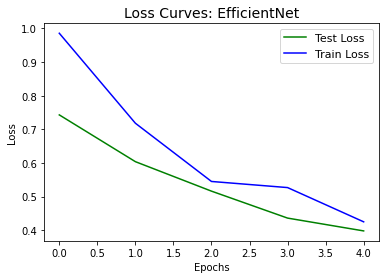

In [17]:
plot_loss_curve(effnet_b2_results)

#### Saving the Model

In [18]:
utils.save_model(model=effnet_b2,
                 target_dir="/content/models",
                 model_name="EffNetB2.pth")

Saving Model to: /content/models/EffNetB2.pth
Model Successfully Saved to: /content/models/EffNetB2.pth


#### Creating the EffNetB2 Feature Extractor

In [19]:
# Getting the Size (in bytes) of the Model and Convert it to `MB`
effnet_b2_size = Path("/content/models/EffNetB2.pth").stat().st_size // (1024*1024)

# Getting the Total Parameters of the Model
effnet_b2_num_params = sum(param.numel() for param in effnet_b2.parameters())

# Create a Dictionary with the Model's Statistics
effnet_b2_stats = {"model": "EffNetB2",
                   "test_loss": effnet_b2_results["model_valid_loss"][-1],
                  "test_acc (%)": effnet_b2_results["model_valid_eval"][-1],
                  "number_of_parameters": effnet_b2_num_params,
                  "model_size (MB)": effnet_b2_size}

print(effnet_b2_stats)

{'model': 'EffNetB2', 'test_loss': 0.3977665066719055, 'test_acc (%)': 93.80681818181817, 'number_of_parameters': 7705221, 'model_size (MB)': 29}


### ViT Model

#### Creating a Function to Construct the Model

In [20]:
def create_vit_model(device, num_classes):
    vit_weights = models.ViT_B_16_Weights.DEFAULT
    vit_transforms = vit_weights.transforms()

    vit = models.vit_b_16(weights=vit_weights).to(device)

    for param in vit.parameters():
        param.requires_grad = False

    vit.heads = nn.Sequential(
        nn.Linear(in_features=768,
                  out_features=num_classes)
    ).to(device)

    return vit, vit_transforms

#### Initializing the Model

In [21]:
vit, vit_transforms = create_vit_model(device, 3)

summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

#### Creating Model's Data Loaders

In [22]:
train_dl_vit, tets_dl_vit, class_names = data_setup.create_dataloaders(train_dir=train_path,
                                                                       test_dir=test_path,
                                                                       train_transform=vit_transforms,
                                                                       test_transform=vit_transforms,
                                                                       batch_size=32)

#### Training the Model

In [23]:
# Setting Optimizer and Loss Function
vit_optim = optim.Adam(params=vit.parameters(), lr=1e-3)
vit_loss_fn = nn.CrossEntropyLoss()

vit_results = engine.fit(model=vit,
                         epochs=5,
                         train_dl=train_dl_vit,
                         valid_dl=tets_dl_vit,
                         loss_fn=vit_loss_fn,
                         eval_metric=engine.accuracy_fn,
                         optim=vit_optim)

Starting Process...


  0%|          | 0/5 [00:00<?, ?it/s]

-> Epoch: 1 | Train Loss: 0.6181 | Train Accuracy: 79.17% | Test Loss: 0.2502 | Test Evaluation (%): 96.59%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 2 | Train Loss: 0.2109 | Train Accuracy: 94.79% | Test Loss: 0.1266 | Test Evaluation (%): 97.22%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 3 | Train Loss: 0.1514 | Train Accuracy: 95.62% | Test Loss: 0.0977 | Test Evaluation (%): 98.12%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 4 | Train Loss: 0.1400 | Train Accuracy: 96.88% | Test Loss: 0.0857 | Test Evaluation (%): 97.84%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 5 | Train Loss: 0.0995 | Train Accuracy: 96.88% | Test Loss: 0.0738 | Test Evaluation (%): 98.75%
----------------------------

#### Inspecting ViT Loss Curves

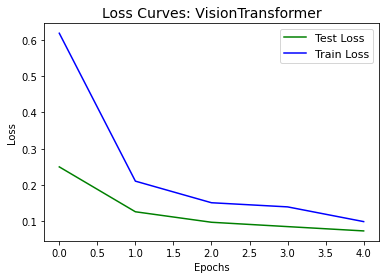

In [24]:
plot_loss_curve(vit_results)

#### Saving the Model

In [25]:
utils.save_model(model=vit,
                 target_dir="/content/models",
                 model_name="ViT.pth")

Saving Model to: /content/models/ViT.pth
Model Successfully Saved to: /content/models/ViT.pth


#### Creating the ViT Feature Extractor

In [26]:
vit_size = Path("/content/models/ViT.pth").stat().st_size // (1024*1024)
vit_num_params = sum(param.numel() for param in vit.parameters())

# Create a Dictionary with the Model's Statistics
vit_stats = {"model": "ViT",
             "test_loss": vit_results["model_valid_loss"][-1],
             "test_acc (%)": vit_results["model_valid_eval"][-1],
             "number_of_parameters": vit_num_params,
             "model_size (MB)": vit_size}

print(vit_stats)

{'model': 'ViT', 'test_loss': 0.07384280823171138, 'test_acc (%)': 98.75, 'number_of_parameters': 85800963, 'model_size (MB)': 327}


## Making Predictions with our Models and Timing them

**Note**: We time the predictions one by one rather than by batch because when our Model is deployed, it will likely only be making a prediction on one image at a time. As in, someone takes a photo and our model predicts on that single image.

To do so, we'll use Python's `pathlib.Path("target_dir").glob("*/*.jpg"))` to find all of the filepaths in a target directory with the extension `.jpg`

In [27]:
test_data_paths = list(test_path.glob("*/*.jpg"))

print(len(test_data_paths))
print(test_data_paths[3], test_data_paths[9])

150
/content/data/pizza_steak_sushi_20_percent/test/steak/1302563.jpg /content/data/pizza_steak_sushi_20_percent/test/steak/1972463.jpg


In [28]:
def pred_and_store(model, paths_list, transform, class_names):
    # Creating a List to store prediction Dictionaires
    pred_list = []

    for path in tqdm(paths_list):
        # Creating a Dictionary to store the Model's Predicitons
        pred_dict = {}

        # Passing the Path and the Class name of the Image
        pred_dict["image_path"] = str(path)
        pred_dict["class_name"] = path.parent.stem

        # Starting the timer
        start = timer()

        # Opening, Transforming and Moving the Image to Device
        with Image.open(path) as img:
            transformed_image = transform(img).unsqueeze(dim=0).to(next(model.parameters()).device)

        # Making Predictions
        model.eval()
        with torch.inference_mode():
            model_logits = model(transformed_image)
            model_probs = torch.softmax(model_logits, dim=1)
            model_label = model_probs.argmax(dim=1)
            pred_class = class_names[model_label.cpu()]

            # Adding Data to the Dictionary (round's second argument is the total decimal places)
            pred_dict["pred_prob"] = round(model_probs.max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # Ending the timer
            pred_dict["time_for_pred"] = round(timer() - start, 2)

        # Storing if the Prediction is the Correct one
        pred_dict["correct"] = (pred_class == pred_dict["class_name"])

        # Adding the Prediction Dictionary to the List
        pred_list.append(pred_dict)

    # Return the List
    return pred_list

### EffNetB2 Model

In [29]:
# We will start with the EffNetB2 Model
effnet_b2_test_dicts = pred_and_store(model=effnet_b2,
                                      paths_list=test_data_paths,
                                      transform=effnet_b2_transforms,
                                      class_names=class_names)

  0%|          | 0/150 [00:00<?, ?it/s]

In [30]:
# Printing some Results
print(effnet_b2_test_dicts[3])
print(effnet_b2_test_dicts[90])
print(effnet_b2_test_dicts[120])

{'image_path': '/content/data/pizza_steak_sushi_20_percent/test/steak/1302563.jpg', 'class_name': 'steak', 'pred_prob': 0.9554, 'pred_class': 'steak', 'time_for_pred': 0.03, 'correct': True}
{'image_path': '/content/data/pizza_steak_sushi_20_percent/test/sushi/715227.jpg', 'class_name': 'sushi', 'pred_prob': 0.5274, 'pred_class': 'sushi', 'time_for_pred': 0.03, 'correct': True}
{'image_path': '/content/data/pizza_steak_sushi_20_percent/test/pizza/771336.jpg', 'class_name': 'pizza', 'pred_prob': 0.809, 'pred_class': 'pizza', 'time_for_pred': 0.03, 'correct': True}


In [31]:
# Turning the Results a Pandas DataFrame
effnetb2_test_df = pd.DataFrame(effnet_b2_test_dicts)
effnetb2_test_df.head(3)

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,/content/data/pizza_steak_sushi_20_percent/tes...,steak,0.9308,steak,0.05,True
1,/content/data/pizza_steak_sushi_20_percent/tes...,steak,0.8727,steak,0.02,True
2,/content/data/pizza_steak_sushi_20_percent/tes...,steak,0.9111,steak,0.02,True


In [32]:
# We can Get the Total Correct Predictions
print(effnetb2_test_df.correct.value_counts())

True     141
False      9
Name: correct, dtype: int64


In [33]:
# We can also Get the Average Time (s) per Prediction
print(round(effnetb2_test_df.time_for_pred.mean(), 4))

0.0267


In [34]:
# Finally Adding the Average `time_for_pred` into the EffnetB2 features
effnet_b2_stats["time_per_pred"] = round(effnetb2_test_df.time_for_pred.mean(), 4)

print(effnet_b2_stats)

{'model': 'EffNetB2', 'test_loss': 0.3977665066719055, 'test_acc (%)': 93.80681818181817, 'number_of_parameters': 7705221, 'model_size (MB)': 29, 'time_per_pred': 0.0267}


### ViT Model

In [35]:
vit_test_dicts = pred_and_store(model=vit,
                                paths_list=test_data_paths,
                                transform=vit_transforms,
                                class_names=class_names)

  0%|          | 0/150 [00:00<?, ?it/s]

In [36]:
# Printing some Results
print(vit_test_dicts[3])
print(vit_test_dicts[90])
print(vit_test_dicts[120])

{'image_path': '/content/data/pizza_steak_sushi_20_percent/test/steak/1302563.jpg', 'class_name': 'steak', 'pred_prob': 0.9754, 'pred_class': 'steak', 'time_for_pred': 0.03, 'correct': True}
{'image_path': '/content/data/pizza_steak_sushi_20_percent/test/sushi/715227.jpg', 'class_name': 'sushi', 'pred_prob': 0.9662, 'pred_class': 'sushi', 'time_for_pred': 0.02, 'correct': True}
{'image_path': '/content/data/pizza_steak_sushi_20_percent/test/pizza/771336.jpg', 'class_name': 'pizza', 'pred_prob': 0.9982, 'pred_class': 'pizza', 'time_for_pred': 0.02, 'correct': True}


In [37]:
# Turning the Results a Pandas DataFrame
vit_test_df = pd.DataFrame(vit_test_dicts)
vit_test_df.head(3)

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,/content/data/pizza_steak_sushi_20_percent/tes...,steak,0.9489,steak,0.04,True
1,/content/data/pizza_steak_sushi_20_percent/tes...,steak,0.8426,steak,0.03,True
2,/content/data/pizza_steak_sushi_20_percent/tes...,steak,0.7904,steak,0.03,True


In [38]:
# We can Get the Total Correct Predictions
print(vit_test_df.correct.value_counts())

True     148
False      2
Name: correct, dtype: int64


In [39]:
# We can also Get the Average Time (s) per Prediction
print(round(vit_test_df.time_for_pred.mean(), 4))

0.0236


In [40]:
# Finally Adding the Average `time_for_pred` into the EffnetB2 features
vit_stats["time_per_pred"] = round(vit_test_df.time_for_pred.mean(), 4)

print(vit_stats)

{'model': 'ViT', 'test_loss': 0.07384280823171138, 'test_acc (%)': 98.75, 'number_of_parameters': 85800963, 'model_size (MB)': 327, 'time_per_pred': 0.0236}


## Comparing Model Results

In [41]:
# Creating a Data Frame to Compare the Models
df = pd.DataFrame([effnet_b2_stats, vit_stats])

df.head()

,model,test_loss,test_acc (%),number_of_parameters,model_size (MB),time_per_pred
0,EffNetB2,0.397767,93.806818,7705221,29,0.0267
1,ViT,0.073843,98.750000,85800963,327,0.0236


In [42]:
# We can Compare them by also Looking at the Ratios Between them
ratios = pd.DataFrame(data=(round(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"], 4)),
                      columns=["ViT / EffNetB2"]).T

ratios.head()

,test_loss,test_acc (%),number_of_parameters,model_size (MB),time_per_pred
ViT / EffNetB2,0.1856,1.0527,11.1354,11.2759,0.8839


## Bringing FoodVision Mini to Life by Creating a Gradio demo (using EffNetB2 Model)

In [43]:
!pip -q install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 17.7 MB/s eta 0:0

In [44]:
import gradio as gr

### What is `Gradio`?
* Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!

* Gradio provide us an `Interface`, that looks like:
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-gradio-workflow.png" width=800>

### Creating the Function that Maps Inputs to Outputs

In [45]:
# Moving the Model to CPU
effnet_b2.to("cpu")


def predict(img):
    start_time = timer()

    transformed_img = effnet_b2_transforms(img).unsqueeze(dim=0) # Adding Batch Dimension

    effnet_b2.eval()
    with torch.inference_mode():
        preds_probs = torch.softmax(effnet_b2(transformed_img), dim=1)

    pred_labels_and_probs = {class_names[i]: round(preds_probs[0][i].item(), 4) for i in range(len(class_names))}

    pred_time = round(timer() - start_time, 5)

    return pred_labels_and_probs, pred_time

In [46]:
# Testing this Function for a Random Image
from random import sample

random_image_path = sample(test_data_paths, k=1)[0]
image = Image.open(random_image_path)

print(f"[INFO] Predicting on image at path: {random_image_path}\n")

pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: /content/data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg

Prediction label and probability dictionary: 
{'pizza': 0.4798, 'steak': 0.1809, 'sushi': 0.3393}
Prediction time: 0.27636 seconds


### Creating a Gradio Interface

In [47]:
# Creating an Examples List
example_list = [[str(filepath)] for filepath in sample(test_data_paths, k=3)]

In [48]:
# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."

# Create the Gradio demo
demo = gr.Interface(fn=predict,                                                # Mapping function from input to output
                    inputs=gr.Image(type="pil"),                               # What are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # What are the outputs?
                             gr.Number(label="Prediction time (s)")],          # (Our fn has two outputs, therefore we have two outputs)
                    examples=example_list, 
                    title=title,
                    description=description)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True)  # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://01edc738d3c54614d1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


## To make our FoodVision Mini demo more permanent, we can package it into an app and upload it to [Hugging Face Spaces](https://huggingface.co/spaces/launch).

### What is Hugging Face Spaces?

Hugging Face Spaces is a resource that allows you to host and share machine learning apps.

If having a good GitHub portfolio showcases your coding abilities, having a good Hugging Face portfolio can showcase your machine learning abilities.

###  Deployed Gradio App Structure

To upload our demo Gradio app, we'll want to put everything relating to it into a single directory. This directory could look like:
```
demos/
└── foodvision_mini/
    ├── model.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

Where:

* `model.pth`: Our trained PyTorch model file.
* `app.py`: Contains our Gradio app (similar to the code that launched the app).
* `examples/`: Contains example images to use with our Gradio app.
* `model.py`: Contains the model defintion as well as any transforms assosciated with the model.
* `requirements.txt`: Contains the dependencies to run our app such as **torch**, **torchvision** and **gradio**.

### Creating the Directory

In [98]:
import shutil

In [99]:
# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("/content/demos/foodvision_mini/")

In [100]:
# Removing the files if the `foodvision_mini_demo_path` directory exists
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)

# Create the directoty if doesn't exists
foodvision_mini_demo_path.mkdir(parents=True,
                                exist_ok=True)

print(foodvision_mini_demo_path)

/content/demos/foodvision_mini


### Creating the `examples` Directory


In [101]:
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True,
                                    exist_ok=True)

# Collecting 7 Random Images
image_examples = [Path(img_paths) for img_paths in sample(test_data_paths, k=7)]

# Copying the list to Directory
for image_example in image_examples:
    destination = foodvision_mini_examples_path / image_example.name
    print(f"[INFO] Copying {image_example} to {destination}")
    shutil.copy2(src=image_example, dst=destination)

[INFO] Copying /content/data/pizza_steak_sushi_20_percent/test/sushi/3227791.jpg to /content/demos/foodvision_mini/examples/3227791.jpg
[INFO] Copying /content/data/pizza_steak_sushi_20_percent/test/pizza/788315.jpg to /content/demos/foodvision_mini/examples/788315.jpg
[INFO] Copying /content/data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg to /content/demos/foodvision_mini/examples/1335842.jpg
[INFO] Copying /content/data/pizza_steak_sushi_20_percent/test/steak/1882831.jpg to /content/demos/foodvision_mini/examples/1882831.jpg
[INFO] Copying /content/data/pizza_steak_sushi_20_percent/test/pizza/380739.jpg to /content/demos/foodvision_mini/examples/380739.jpg
[INFO] Copying /content/data/pizza_steak_sushi_20_percent/test/pizza/3497151.jpg to /content/demos/foodvision_mini/examples/3497151.jpg
[INFO] Copying /content/data/pizza_steak_sushi_20_percent/test/steak/595836.jpg to /content/demos/foodvision_mini/examples/595836.jpg


### Moving out Model to Directory

In [102]:
effnet_b2_path = "/content/models/EffNetB2.pth"
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnet_b2_path.split("/")[-1]

print(f"[INFO] Copying {effnet_b2_path} to {effnetb2_foodvision_mini_model_destination}")

# We can also create a try/except block
shutil.copy2(src=effnet_b2_path, dst=effnetb2_foodvision_mini_model_destination)

[INFO] Copying /content/models/EffNetB2.pth to /content/demos/foodvision_mini/EffNetB2.pth


PosixPath('/content/demos/foodvision_mini/EffNetB2.pth')

### Turning out EffNetB2 Model into a Python Script

In [103]:
%%writefile /content/demos/foodvision_mini/model.py
from torchvision import models
from torch import nn


def create_effnetb2_model(num_classes=3):

    # Creating EffNetB2 pretrained Weights, Transforms and Model
    weights = models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = models.efficientnet_b2(weights=weights)

    # Freezing all layers in Base Model
    for param in model.parameters():
        param.requires_grad = False

    # Changing the Classifier Head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing /content/demos/foodvision_mini/model.py


### Turning our FoodVision Mini Gradio App into a Python Script

We've now got a `model.py` script as well as a path to a saved Model `state_dict` that we can load in.

Time to construct `app.py`.

We call it `app.py` because by default when you create a **HuggingFace Space**, it looks for a file called `app.py` to run and host (though you can change this in settings).

In [104]:
%%writefile /content/demos/foodvision_mini/app.py
### 1. Importing Libraries and Setting `class_names` ###
import torch

import gradio as gr
from timeit import default_timer as timer
from pathlib import Path

from model import create_effnetb2_model


class_names = ["pizza", "steak", "sushi"]


### 2. Creating the Model, Getting Transformations and Loading Parameters ###

effnet_b2, effnet_b2_transforms = create_effnetb2_model(num_classes=len(class_names))
effnet_b2.load_state_dict(torch.load(f="EffNetB2.pth",
                                     map_location=torch.device("cuda"))) # Load it on GPU


### 3. Creating a Function to Map Inputs, Outputs ###

def predict(img):
    start_time = timer()

    # Transforming the image and adding Batch Dimension
    transformed_img = effnet_b2_transforms(img).unsqueeze(dim=0)

    # Make Predictions
    effnet_b2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnet_b2(transformed_img), dim=1)

    pred_labels_and_probs = {class_names[i]: round(pred_probs[0][i].item(), 4) for i in range(len(class_names))}

    return pred_labels_and_probs, (timer() - start_time)


### 4. Initializing the Gradio App ###

title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."

# Create examples list from "examples/" directory
example_list = [[str(example)] for example in Path("examples/").glob("*.jpg")]

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list, 
                    title=title,
                    description=description)

# Launch the demo
demo.launch()

Writing /content/demos/foodvision_mini/app.py


###  Creating a Requirements File for FoodVision Mini

When we deploy our demo app to Hugging Face Spaces, it will search through this file and install the `dependencies` we define so our app can run.

The good news is, there's only three:
1. `torch==1.13.1`
2. `torchvision==0.14.1`
3. `gradio==3.22.1`

In [105]:
%%writefile /content/demos/foodvision_mini/requirements.txt
torch==1.13.1
torchvision==0.14.1
gradio==3.22.1

Writing /content/demos/foodvision_mini/requirements.txt


## Deploying our FoodVision Mini app to HuggingFace Spaces

We've got a file containing our FoodVision Mini demo, now how do we get it to run on Hugging Face Spaces?

There are two main options for uploading to a Hugging Face Space (also called a Hugging Face Repository, similar to a git repository):
* [Uploading via the Hugging Face Web interface](https://huggingface.co/docs/hub/repositories-getting-started#adding-files-to-a-repository-web-ui)
* [Uploading via the command line or terminal](https://huggingface.co/docs/hub/repositories-getting-started#terminal)

To begin uploading our files to `Hugging Face`, let's now download them from Google Colab.

In [106]:
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 52%)
  adding: EffNetB2.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/3497151.jpg (deflated 1%)
  adding: examples/3227791.jpg (deflated 1%)
  adding: examples/380739.jpg (deflated 0%)
  adding: examples/788315.jpg (deflated 0%)
  adding: examples/595836.jpg (deflated 1%)
  adding: examples/1335842.jpg (deflated 0%)
  adding: examples/1882831.jpg (deflated 0%)
  adding: model.py (deflated 45%)
  adding: requirements.txt (deflated 6%)


In [107]:
# Downloading the `zip` file from Google Colab (into /user)
from google.colab import files
files.download("/content/demos/foodvision_mini.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Last Step

1. Sign up for a Hugging Face account.
2. Start a new Hugging Face Space by going to your profile and then clicking `New Space`.
    * **Note**: A Space in Hugging Face is also known as a "code repository" (a place to store your code/files) or "repo" for short.
3. Give the Space a name, for example, mine is called `PJF/foodvision_mini`.
4. Select a license (I used MIT).
5. Select `Gradio` as the Space SDK (software development kit).
6. Choose whether your Space is it's public or private.
7. Click `Create Space`.
8. Clone the repo locally by running something like: git clone https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME] in terminal or command prompt.
    * **Note**: You can also add files via uploading them under the `Files and versions` tab.
9. Copy/move the contents of the downloaded `foodvision_mini` folder to the cloned repo folder.
10. To upload and track larger files (e.g. files over 10MB or in our case, our PyTorch model file) you'll need to install `Git LFS` (which stands for "git large file storage").
11. After you've installed Git LFS, you can activate it by running `git lfs install`.
12. In the `foodvision_mini` directory, track the files over 10MB with Git LFS with `git lfs track "*.file_extension"` (etc git lfs track "EffNetB2.pth")
13. `git add .gitattributes`
14. `git add *`
15. `git commit`
16. `git push`
17. Wait 3-5 minutes for the build to happen (future builds are faster) and your app to become live!
